# Analysis of the Hydronic Network
---

In [1]:
from deps import load_packages
load_packages()

In [2]:
import jupyter_addons as ja
ja.set_css()

## Let's Import What We'll Need

In [3]:
from hvac import Quantity
from hvac.fluid_flow import load_network, PseudoConduit, SystemCurve
from hvac.fluid_flow.utils import plot_curves

In [4]:
Q_ = Quantity

## Load the Hydronic Network back into this Notebook

In the previous notebook "Design of a Hydronic Network" we saved our `PipeNetwork` object on the file path:

In [5]:
file_path = "./networks/hydronic_network.pickle"

Now, let's load this object again from disk:

In [6]:
pipe_network = load_network(file_path)

## Add a Pseudo Conduit with a Fixed Pressure Difference

A pseudo conduit, as the name suggests, is not a real conduit in a pipe network. We use it to represent a fixed pressure difference between two nodes.

![scheme](./images/hydronic_network.png)

From the design of the hydronic pipe network it follows that we need a pressure difference of about 39 kPa between end node R0 and start node S0 to establish the design volume flow rates in the pipe network. In order to analyze the pipe network, we add a `PseudoConduit` object between the end node and the start node of the network with a fixed pressure difference of 39 kPa.

In [7]:
pseudo_conduit = PseudoConduit.create(fixed_pressure_drop=Q_(-39, 'kPa'))

The start node of the network is at a pressure that is 39 kPa higher than the pressure at the end node of the network. If there would be a real conduit between the start and the end node of the network, there would be a flow of water from the start node towards the end node. The direction of this flow would be opposite to the positive, clock-wise sense of the loop L1, as can be deduced from the scheme above. This is the reason why we need to add a minus sign. It can also be noticed that the fixed pressure difference between the end node and the start node is a pressure rise rather than a pressure drop.

After the pseudo conduit has been created, we still need to add it to the network:

In [8]:
pipe_network.add_conduit(
    conduit=pseudo_conduit,
    conduit_ID='P13',
    start_node_ID='R0',
    end_node_ID='S0',
    loop_ID='L1'
)

## More about Loops

Before we move on, let's first go back to the pipe configuration csv-file that we discussed in the notebook "Design of a Hydronic Network" and which is displayed again below: 

In [9]:
import pandas as pd

table = pd.read_csv('./networks/ex1_closed-pipe-network-design.csv')
ja.display_table(table)

Inside the column *loop_ID*, we have specified the loop or loops to which each pipe in the network belongs. For example, pipe 5 belongs to two loops L1 and L2. You must enter the two loop IDs between brackets and separate them with a comma, otherwise the program will give an error. 

The sense of the volume flow rates in the pipes is referenced to the sense of the loop the pipes belong to. By convention a clock-wise loop sense is considered to be positive. If the arrow of the volume flow rate in a pipe points in the same direction as the loop arrow, the volume flow rate has a positive sign, otherwise you must give it a negative sign. In the case a pipe belongs to two loops, the sign of the volume flow rate is referenced to the positive sense of the first mentioned loop. In the second loop the flow sign will always be opposite to the flow sign in the first loop, as can be observed in the network scheme above.

## Analyze the Pipe Network

Once alle pipes have been assigned a loop ID, or two loop IDs, and the pseudo conduit has been added between the end node and the start node of the network, we can let the program analyze the network with the Hardy Cross method:

In [10]:
i = pipe_network.analyze(tolerance=Q_(1, 'Pa'), i_max=500)
i

12

The Hardy Cross method is an iterative solution method to find the volume flow rates in a fluid network. The aim is to find the volume flow rate in each pipe of the network, such that the sum of the pressure differences across the pipes in each loop of the network becomes zero (as demanded by the physical law about conservation of energy). As it may take numerous iterations to find a solution for which the loop pressure differences all become exactly zero, a stop criterium is provided by the `tolerance` parameter. A tolerance of 1 Pa means that the `analyze` method will stop when all loop pressure differences are between 0 and 1 Pa. The parameter `i_max` sets the maximum number of iterations. If no solution has been found within `i_max` iterations, an `OverflowError` excepction will be raised to alert that no solution could be found that fulfills the stop criterium. The volume flow rates we entered in the pipe configuration file are used by the program as an initial guess to start the iterative solving process. Here we use the design flow rates for which we have sized the network.

> **IMPORTANT!**<br>
> When we choose a volume flow rate for each pipe in the network, we must make sure that the sum of the flow rates that arrive at a node is equal to the sum of the flow rates that leave at this same node (as demanded by the physical law about conservation of mass).

When the `analyze` method is finished and has returned, we can take a look at the results:

In [11]:
pipe_table1 = pipe_network.get_pipe_table()
ja.display_table(pipe_table1)

As could have been expected, the volume flow rates are still close to the initial design values, as we have added a fixed pressure rise of 39 kPa that is close to what was calculated when designing the network and because we haven't changed anything yet to the configuration of the pipe network.

In [12]:
ja.display_table(pipe_network.get_flow_path_table())

### Hydraulic Resistance of Pipe Network

In [13]:
ja.display_list([
    f"network hydraulic resistance: <b>{pipe_network.hydraulic_resistance.to('Pa / (m ** 3 / s) ** 2'):~P.5g}</b>"
])

In [14]:
system_curve1 = SystemCurve.create(pipe_network.hydraulic_resistance, name='system curve 1')

We will this `SystemCurve` object later on when we will display different system curves of the pipe network.

## Effect of Closing Control Valves

What will happen to the volume flow rates in the network when we close the control valves in cross-overs P6 and P7 to 50 % opening? To find this out, we first set the valve opening of these control valves to 50 % of the fully open position:

In [15]:
pipe_network.set_control_valve_opening('P6', percent_open=50)
pipe_network.set_control_valve_opening('P7', percent_open=50)

Then we run the `analyze` method again:

In [16]:
i = pipe_network.analyze(tolerance=Q_(1, 'Pa'), i_max=500)
i

155

Now can display the pipe table again, to check the volume flow rates in the network. 

In [17]:
pipe_table2 = pipe_network.get_pipe_table()
ja.display_table(pipe_table2)

In [18]:
ja.display_table(pipe_network.get_flow_path_table())

### Comparing volume flow rates

In [19]:
data = {
    'pipe_IDs': pipe_table1.iloc[:, 0].copy(),
    'V_1': pipe_table1.iloc[:, 4].copy(),
    'V_2': pipe_table2.iloc[:, 4].copy()
}
comp_table = pd.DataFrame(data)
comp_table['abs. difference'] = comp_table['V_2'] - comp_table['V_1']
comp_table['% difference'] = comp_table['abs. difference'] / comp_table['V_1'] * 100
ja.display_table(comp_table)

For the same pressure rise of 39 kPa between the start and the end node of the network, the total flow rate into (and out of) the network has been reduced. In the cross-overs P6 and P7 the volume flow rate has been reduced approximately by 35 % and 44 % respectively. However, in the cross-overs P5 and P8 the volume flow rates have slightly increased, because there is less pressure drop in the supply and return header.

### Hydraulic Resistance of Pipe Network

In [20]:
ja.display_list([
    f"network hydraulic resistance: <b>{pipe_network.hydraulic_resistance.to('Pa / (m ** 3 / s) ** 2'):~P.5g}</b>"
])

In [21]:
system_curve2 = SystemCurve.create(pipe_network.hydraulic_resistance, name='system curve 2')

## Plot the System Curves

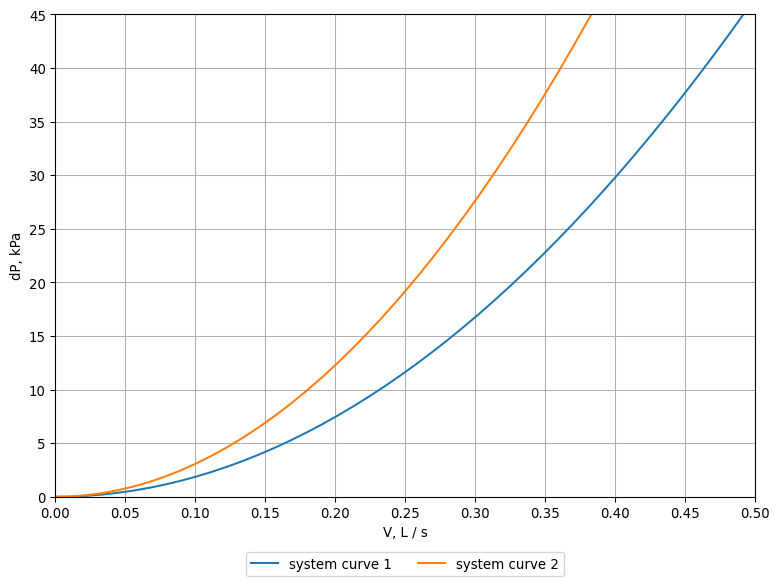

In [22]:
chart = plot_curves(
    pump_curves=[],
    system_curves=[system_curve1, system_curve2],
    working_point=None,
    fig_size=(8, 6),
    V_step=Q_(0.05, 'L / s'),
    V_max=Q_(0.55, 'L / s'),
    dP_step=Q_(5, 'kPa'),
    dP_max=Q_(50, 'kPa'),
    V_unit='L / s',
    dP_unit='kPa'
)

chart.show()